In [1]:
import pandas as pd
import zipfile
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

In [6]:
url = 'https://raw.githubusercontent.com/esnt/Data/refs/heads/main/Names/popular_names.csv'
df = pd.read_csv(url)

In [11]:
names_file = 'names.zip'
with zipfile.ZipFile(names_file, 'r') as z:
    dfs = []
    files = [file for file in z.namelist() if file.endswith('.txt')]
    for file in files:
        with z.open(file) as f:
            df = pd.read_csv(f)
            df.columns = ['name', 'sex', 'count']
            df['year'] = file[3:7]
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

df['total_births'] = df.groupby(['year', 'sex'])['count'].transform('sum')
df['prop'] = df['count'] / df['total_births']
df['rank'] = df.groupby(['year', 'sex'])['count'].rank(method='first', ascending=False)



In [12]:
noi = 'Ben'

## Name Specific EDA

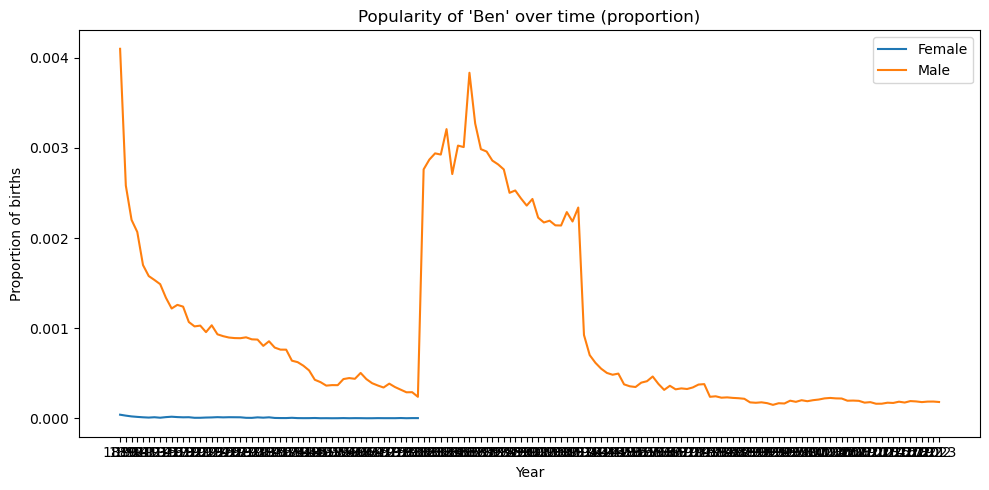

In [13]:
df['total_births'] = df.groupby(['year', 'sex'])['count'].transform('sum')
df['prop'] = df['count'] / df['total_births']
plot_male = True
plot_female = True

name_df = df[df['name'] == noi]

plt.figure(figsize=(10,5))
if plot_female:
    sns.lineplot(data=name_df[name_df['sex'] == 'F'], x='year', y='prop', label='Female')
if plot_female:
    sns.lineplot(data=name_df[name_df['sex'] == 'M'], x='year', y='prop', label='Male')

plt.title(f"Popularity of '{noi}' over time (proportion)")
plt.xlabel('Year')
plt.ylabel('Proportion of births')
plt.tight_layout()
plt.show()

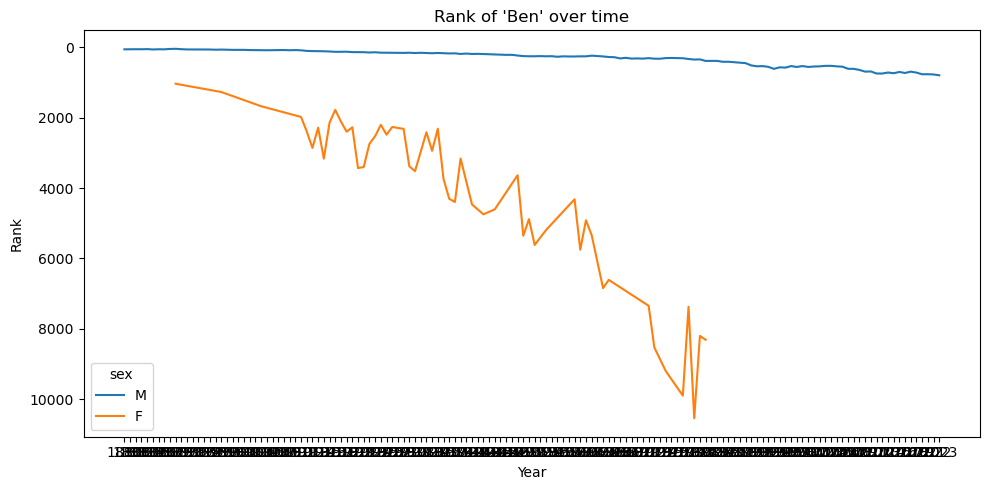

In [14]:

name_df = df[df['name'] == noi]

plt.figure(figsize=(10,5))
sns.lineplot(data=name_df, x='year', y='rank', hue='sex')
plt.gca().invert_yaxis()  # rank 1 at top
plt.title(f"Rank of '{noi}' over time")
plt.xlabel('Year')
plt.ylabel('Rank')
plt.tight_layout()
plt.show()

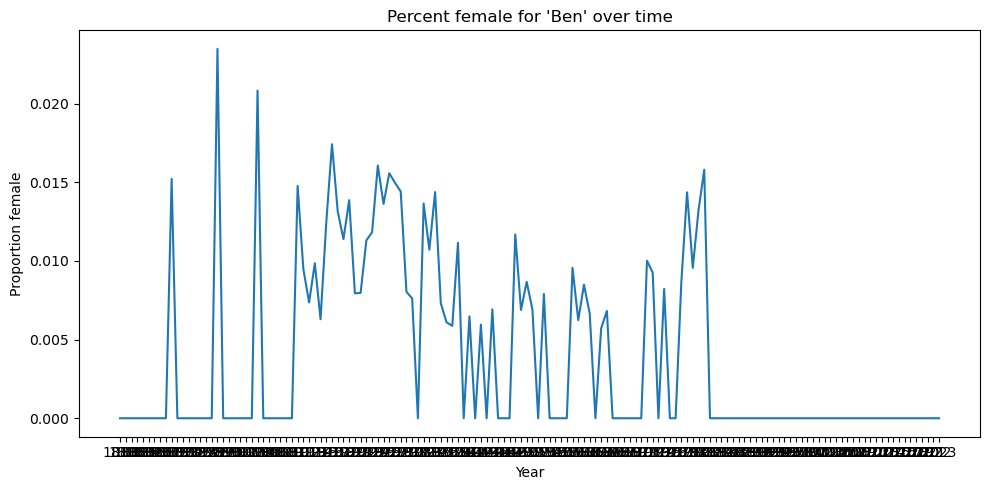

In [15]:
name_df = df[df['name'] == noi]
gender_counts = name_df.pivot_table(index='year', columns='sex', values='count', fill_value=0)
gender_counts['percent_female'] = gender_counts['F'] / (gender_counts['F'] + gender_counts['M'])

plt.figure(figsize=(10,5))
plt.plot(gender_counts.index, gender_counts['percent_female'])
plt.title(f"Percent female for '{noi}' over time")
plt.ylabel('Proportion female')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

In [16]:
name_data = df[df['name'] == noi].copy()
yearly_counts = name_data.groupby(['year', 'sex']).sum()['count'].unstack(fill_value=0)
yearly_counts['Total'] = yearly_counts['M'] + yearly_counts['F']
yearly_counts['Male_Ratio'] = yearly_counts['M'] / yearly_counts['Total']
yearly_counts['Female_Ratio'] = yearly_counts['F'] / yearly_counts['Total']
yearly_counts = yearly_counts.reset_index()

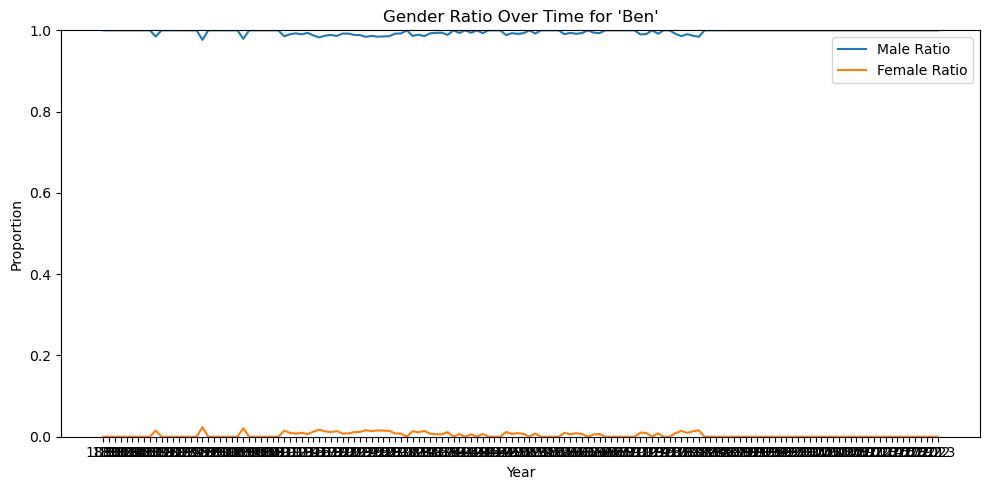

In [17]:
plt.figure(figsize=(10, 5))

plt.plot(yearly_counts['year'], yearly_counts['Male_Ratio'], label='Male Ratio')
plt.plot(yearly_counts['year'], yearly_counts['Female_Ratio'], label='Female Ratio')

plt.title(f"Gender Ratio Over Time for '{noi}'")
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

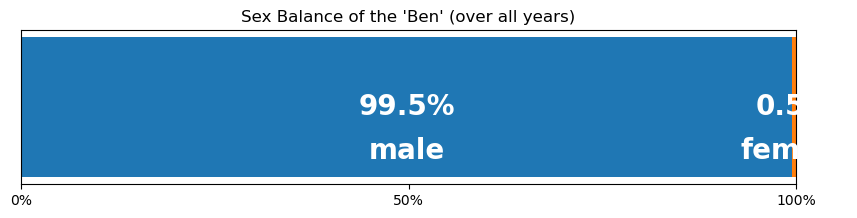

In [18]:
sex_counts = name_data.groupby('sex').sum()['count']
male_count = sex_counts.get('M', 0)
female_count = sex_counts.get('F', 0)
total_count = male_count + female_count
if total_count > 0:
    male_ratio = male_count / total_count
    female_ratio = female_count / total_count

    fig, ax = plt.subplots(figsize=(10, 2))

    # Create a stacked bar representing male and female ratios
    ax.barh(0, male_ratio,  label='Male')
    ax.barh(0, female_ratio, left=male_ratio,  label='Female')

    # Customize the chart
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(['0%', '50%', '100%'])
    ax.set_yticks([])  # Hide y-axis ticks

    # Add labels to display the ratios
    ax.text(male_ratio / 2, 0, f"{male_ratio * 100:.1f}%", va='center', 
            ha='center', color='white', 
            fontweight='bold',
            fontsize=20)
    ax.text(male_ratio / 2, -.25, "male", va='center', 
            ha='center', color='white', 
            fontweight='bold',
            fontsize=20)
    ax.text(male_ratio + female_ratio / 2, 0, f"{female_ratio * 100:.1f}%", va='center', 
            ha='center', color='white', 
            fontweight='bold',
            fontsize=20)
    ax.text(male_ratio + female_ratio / 2, -.25, "female", va='center', 
            ha='center', color='white', 
            fontweight='bold',
            fontsize=20)
    plt.title(f"Sex Balance of the '{noi}' (over all years)")
    plt.show()

## Year Summaries

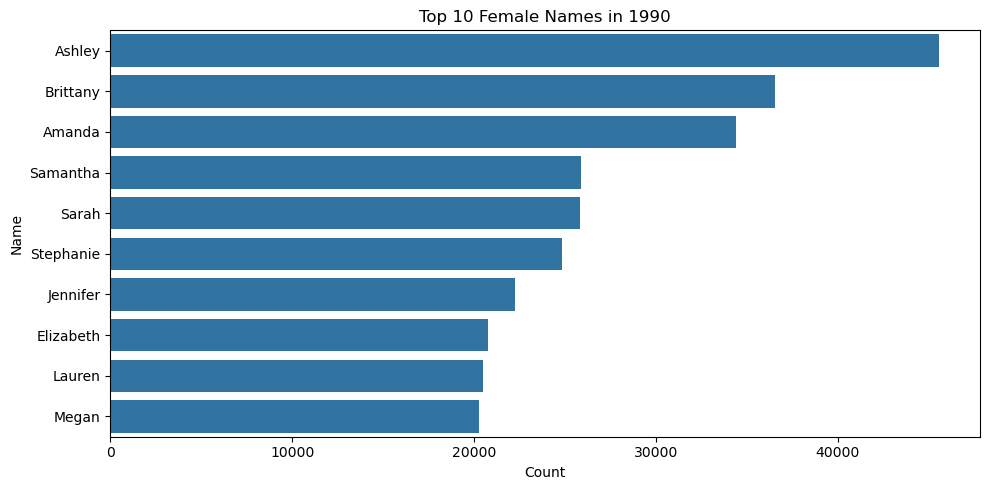

In [19]:
year_of_interest = "1990"
top_names = df[df['year'] == year_of_interest]
top_female = top_names[top_names['sex'] == 'F'].nlargest(10, 'count')

plt.figure(figsize=(10,5))
sns.barplot(data=top_female, x='count', y='name')
plt.title(f"Top 10 Female Names in {year_of_interest}")
plt.xlabel('Count')
plt.ylabel('Name')
plt.tight_layout()
plt.show()

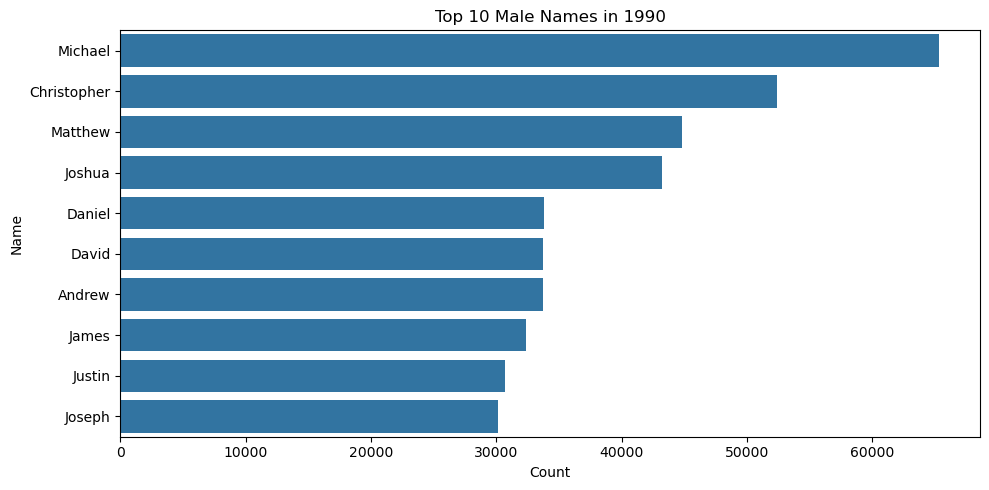

In [20]:
top_male = top_names[top_names['sex'] == 'M'].nlargest(10, 'count')

plt.figure(figsize=(10,5))
sns.barplot(data=top_male, x='count', y='name')
plt.title(f"Top 10 Male Names in {year_of_interest}")
plt.xlabel('Count')
plt.ylabel('Name')
plt.tight_layout()
plt.show()

In [21]:
def top_names_by_group(df_group, label):
    grouped = df_group.groupby(['sex', 'name'], as_index=False)['count'].sum()

    # Get top N per sex without triggering the warning
    top_f = grouped[grouped['sex'] == 'F'].nlargest(top_n, 'count')
    top_m = grouped[grouped['sex'] == 'M'].nlargest(top_n, 'count')

    top_grouped = pd.concat([top_f, top_m], ignore_index=True)
    top_grouped['Category'] = label
    return top_grouped

In [ ]:
def plot_top_new_names_2x2(df, year, top_n=5, fontname='monospace', fontsize=12):
    # Prep name sets
    names_before = set(df[df['year'] < year]['name'])
    names_after = set(df[df['year'] > year]['name'])
    df_year = df[df['year'] == year].copy()
    new_names = set(df_year['name']) - names_before
    df_new = df_year[df_year['name'].isin(new_names)].copy()
    df_new['appears_again'] = df_new['name'].apply(lambda x: x in names_after)

    # Setup figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle(f"Top {top_n} New Names in {year}", fontsize=16)

    # Panel mapping
    panel_info = [
        ('F', True, 'Female — Appears Again', (0, 0)),
        ('F', False, 'Female — One-Year Only', (0, 1)),
        ('M', True, 'Male — Appears Again', (1, 0)),
        ('M', False, 'Male — One-Year Only', (1, 1))
    ]

    for sex, appears, title, pos in panel_info:
        ax = axes[pos]
        subset = df_new[(df_new['sex'] == sex) & (df_new['appears_again'] == appears)]
        top = subset.groupby('name', as_index=False)['count'].sum().nlargest(top_n, 'count')

        lines = [f"{row['name']} ({int(row['count'])})" for _, row in top.iterrows()]
        text = "\n".join(lines) if lines else "No names"

        ax.axis('off')
        ax.set_title(title, fontsize=fontsize + 2)
        ax.text(
            0.5, 0.5, text,
            ha='center', va='center',
            fontsize=fontsize,
            family=fontname
        )


    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.close(fig)
    return fig

In [ ]:
plot_top_new_names_2x2(df, year='2000', top_n=5)

## Summaries overall

In [ ]:
import matplotlib.pyplot as plt

# Group by year and sex, then count unique names
unique_names_by_gender = df.groupby(['year', 'sex'])['name'].nunique().reset_index()

# Plot
plt.figure(figsize=(10, 5))
for gender in ['F', 'M']:
    gender_data = unique_names_by_gender[unique_names_by_gender['sex'] == gender]
    plt.plot(gender_data['year'], gender_data['name'], label='Female' if gender == 'F' else 'Male')

plt.title('Number of Unique Baby Names per Year by Gender')
plt.xlabel('Year')
plt.ylabel('Unique Names')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
total_by_year = df.groupby('year')['count'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=total_by_year, x='year', y='count', ax=ax)
ax.set_title('Total Number of Births per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Birth Count')
plt.show()


In [ ]:
births_by_sex = df.groupby(['year', 'sex'])['count'].sum().unstack().fillna(0)
births_by_sex['Total'] = births_by_sex['F'] + births_by_sex['M']
births_by_sex['Male Ratio'] = births_by_sex['M'] / births_by_sex['Total']
births_by_sex['Female Ratio'] = births_by_sex['F'] / births_by_sex['Total']

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(births_by_sex.index, births_by_sex['Male Ratio'], label='Male')
ax.plot(births_by_sex.index, births_by_sex['Female Ratio'], label='Female')
ax.set_title('Gender Ratio Over Time')
ax.set_ylabel('Proportion')
ax.set_xlabel('Year')
ax.legend()
plt.show()

In [ ]:
top_names = df.groupby(['name', 'sex'])['count'].sum().reset_index()
top_names = top_names.sort_values('count', ascending=False).groupby('sex').head(10)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=top_names, x='count', y='name', hue='sex', ax=ax)
ax.set_title('Top 10 Names of All Time by Sex')
ax.set_xlabel('Total Count')
ax.set_ylabel('Name')
plt.show()

In [ ]:
df['first_letter'] = df['name'].str[0]
letter_counts = df.groupby(['year', 'first_letter'])['count'].sum().reset_index()
top_letters = letter_counts.groupby('first_letter')['count'].sum().nlargest(5).index
letter_counts = letter_counts[letter_counts['first_letter'].isin(top_letters)]

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=letter_counts, x='year', y='count', hue='first_letter', ax=ax)
ax.set_title('Top 5 Starting Letters Over Time')
ax.set_ylabel('Birth Count')
ax.set_xlabel('Year')
plt.show()

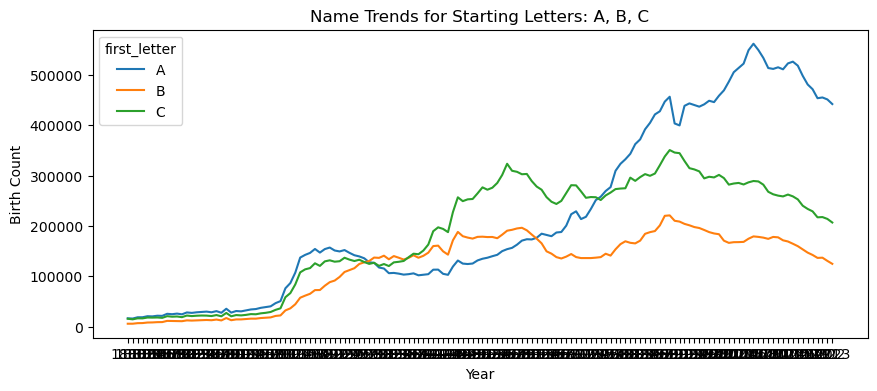

In [22]:
# Ensure the first letter column is there
if 'first_letter' not in df.columns:
    df['first_letter'] = df['name'].str[0]

# List of available starting letters
available_letters = sorted(df['first_letter'].unique())

selected_letters = ['A', 'B', 'C']

# Let user select multiple letters
# selected_letters = st.multiselect(
#     "Choose one or more starting letters:", 
#     available_letters, 
#     default=['A', 'J'] if 'A' in available_letters and 'J' in available_letters else available_letters[:2]
# )

# Only plot if at least one letter is selected
if selected_letters:
    letter_df = df[df['first_letter'].isin(selected_letters)]
    letter_counts = letter_df.groupby(['year', 'first_letter'])['count'].sum().reset_index()

    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(data=letter_counts, x='year', y='count', hue='first_letter', ax=ax)

    ax.set_title(f"Name Trends for Starting Letters: {', '.join(selected_letters)}")
    ax.set_ylabel('Birth Count')
    ax.set_xlabel('Year')
    plt.show()
else:
    pass
    # st.info("Please select at least one letter to see the trend.")